In [35]:
from dotenv import load_dotenv

load_dotenv()

True

In [36]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o-mini')

In [37]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

vector_store = Chroma(
    embedding_function=OpenAIEmbeddings(model='text-embedding-3-large'),
    collection_name='real_estate_tax_collections',
    persist_directory='./real_estate_tax_collections'
)
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [38]:
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """숫자 a와 b를 더한다."""
    
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """숫자 a와 b를 곱한다."""
    
    return a * b

In [39]:
from langchain_core.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever=retriever,
    name='real_estate_tax_retriever',
    description='Contains information about real estate tax up to December 2024'
)

In [40]:
from langchain_tavily import TavilySearch

tavily_search_tool = TavilySearch(
    max_results=5,
    topic="general",
    # include_answer=False,
    # include_raw_content=False,
    # include_images=False,
    # include_image_descriptions=False,
    # search_depth="basic",
    # time_range="day",
    # include_domains=None,
    # exclude_domains=None
)

In [41]:
from langchain_community.tools import ArxivQueryRun
from langchain_community.utilities import ArxivAPIWrapper

arxiv_tool = ArxivQueryRun(api_wrapper=ArxivAPIWrapper(top_k_results=3))

In [ ]:
from langchain_google_community import GmailToolkit
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build

# Can review scopes here https://developers.google.com/gmail/api/auth/scopes
# For instance, readonly scope is 'https://www.googleapis.com/auth/gmail.readonly'
SCOPES = [
    "https://www.googleapis.com/auth/gmail.compose",
    "https://www.googleapis.com/auth/gmail.send"
]

flow = InstalledAppFlow.from_client_secrets_file(
    "./google/gmail_credentials.json",
    SCOPES,
)
credentials = flow.run_local_server(port=0)
api_resource = build("gmail", "v1", credentials=credentials)
gmail_toolkit = GmailToolkit(api_resource=api_resource)
gmail_tool_list = gmail_toolkit.get_tools()

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=73320295733-1h8in52ahpt1pcqoclsiuim4em0i207m.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A56152%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fgmail.compose+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fgmail.send&state=dUEhj5ofIdWmYPpcTUeyOlGneyY5xb&access_type=offline
SCOPES: ['https://www.googleapis.com/auth/gmail.compose', 'https://www.googleapis.com/auth/gmail.send']


In [43]:
tool_list = [add, multiply, retriever_tool, tavily_search_tool, arxiv_tool]
tool_list += gmail_tool_list

In [44]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tool_list)
llm_with_tools = llm.bind_tools(tool_list)

In [45]:
from langgraph.graph import MessagesState

def agent(state: MessagesState) -> MessagesState:
    """
    'agent' Node
    : 주어진 상태에서 메시지를 가져와 LLM 및 도구를 사용하여 응답 메시지를 생성한다.

    Args:
        - state(MessagesState): 메시지 상태를 포함하는 state

    Returns:
        - MessagesState: 응답 메시지를 포함하는 새로운 state
    """
    
    messages = state['messages']
    
    ai_message = llm_with_tools.invoke(messages)
    
    return {'messages': [ai_message]}

In [46]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import tools_condition

graph_builder = StateGraph(MessagesState)

# nodes
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)

# edges
graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    tools_condition     ## 기존 should_continue 기능
)
graph_builder.add_edge('tools', 'agent')

In [47]:
graph = graph_builder.compile()

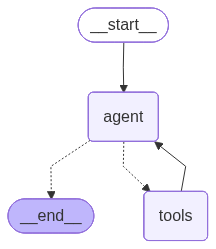

In [48]:
graph

In [49]:
print(gmail_toolkit.api_resource._http.credentials.scopes)

['https://www.googleapis.com/auth/gmail.compose', 'https://www.googleapis.com/auth/gmail.send']


In [ ]:
from langchain_core.messages import HumanMessage

query = "tjdwp3s@gmail.com으로 'Attention Is All You Need' 논문을 요약해서 보내주세요."

for chunk in graph.stream({'messages': [HumanMessage(query)]}, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

tjdwp3s@gmail.com으로 'Attention Is All You Need' 논문을 요약해서 보내주세요.
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_i0uJe6RGVHTNiRKH6uUbVH96)
 Call ID: call_i0uJe6RGVHTNiRKH6uUbVH96
  Args:
    query: Attention Is All You Need
================================= Tool Message =================================
Name: arxiv

Published: 2021-05-06
Title: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet
Authors: Luke Melas-Kyriazi
Summary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifically, we replace the attention layer in a